In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud

from collections import Counter
import numpy as np
import random
import math

import pandas as pd
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

K = 100
C = 3
NUM_EPOCHS = 2
MAX_VOCAB_SIZE = 30000
BATCH_SIZE = 128
LEARNING_RATE = 0.2
EMBEDDING_SIZE = 100


In [3]:
with open("text8/text8.train.txt", "r") as f:
          text = f.read()
text = text.split()

In [4]:
vocab = dict(Counter(text).most_common(MAX_VOCAB_SIZE-1))
vocab["<unk>"] = len(text) - np.sum(list(vocab.values()))

idx_to_word = [word for word in vocab.keys()]
word_to_idx = {word:i for i, word in enumerate(idx_to_word)}

In [5]:
word_counts = np.array([count for count in vocab.values()], dtype=np.float32)
word_freqs = word_counts / np.sum(word_counts)

####玄学操作
word_freqs = word_freqs ** (3./4.)
word_freqs = word_freqs / np.sum(word_freqs)

VOCAB_SIZE = len(idx_to_word)
VOCAB_SIZE

30000

a = [word_to_idx.get(word, ) for word in text]
a

dict = {'Name': 'Runoob', 'Age': 27, 'tel':123}
a = ["Name", "Age"]

b = [word_to_idx.get('the',29999)]
b

In [10]:
class WordEmbeddingDataset(tud.Dataset):
    def __init__(self, text, word_to_idx, idx_to_word, word_freqs, word_counts):
        super(WordEmbeddingDataset, self).__init__()
        self.text_encoded = [word_to_idx.get(word, 29999) for word in text]
        self.text_encoded = torch.LongTensor(self.text_encoded)
        self.word_to_idx= word_to_idx
        self.idx_to_word = idx_to_word
        self.word_freqs = torch.Tensor(word_freqs)
        self.word_counts =  torch.Tensor(word_counts)
    
    def __len__(self):
        return len(self.text_encoded)
    
    def __getitem__(self, idx):
        center_word = self.text_encoded[idx]
        pos_indices = list(range(idx-C,idx)) + list(range(idx+1,idx+C+1))
        pos_indices = [i % len(self.text_encoded) for i in pos_indices]
        pos_words = self.text_encoded[pos_indices]
        neg_words = torch.multinomial(self.word_freqs, K * pos_words.shape[0], True)
        
        return center_word, pos_words, neg_words 

In [11]:
dataset = WordEmbeddingDataset(text, word_to_idx, idx_to_word, word_freqs, word_counts)
dataloader = tud.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [12]:
for i,(c, p, n) in enumerate(dataloader):
    print(c.shape)
    if i>0:
        break

torch.Size([128])
torch.Size([128])


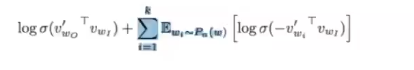

In [14]:
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(EmbeddingModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size)
        self.out_embed = nn.Embedding(self.vocab_size, self.embed_size)
        
        
    def forward(self, input_labels, pos_labels, neg_labels):
        
        input_embedding = self.in_embed(input_labels)
        pos_embedding = self.in_embed(pos_labels)
        neg_embedding = self.in_embed(neg_labels)
        
        input_embedding = input_embedding.unsqueeze(2)
        pos_dot = torch.bmm(pos_embedding, input_embedding).squeeze(2)
        neg_dot = torch.bmm(neg_embedding, -input_embedding).squeeze(2)
        
        log_pos = F.logsigmoid(pos_dot).sum(1)
        log_neg = F.logsigmoid(neg_dot).sum(1)
        
        loss = log_pos + log_neg
        
        return -loss
    
    def input_embedding(self):
        return self.in_embed.weight.data.cpu.numpy()
        
        

In [15]:
model = EmbeddingModel(VOCAB_SIZE, EMBEDDING_SIZE)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
for e in range(NUM_EPOCHS):
    for i, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
        input_labels = input_labels.long()
        pos_labels = pos_labels.long()
        neg_labels = neg_labels.long()
        
        optimizer.zero_grad()
        loss = model(input_labels, pos_labels, neg_labels).mean()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print("epoch:{}, iter: {}, loss:{}".format(e, i, loss.item()))